In [98]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['wine_dataset.csv']


## Reading databases

In [71]:
wines = pd.read_csv("../input/wine_dataset.csv")

## Inspecting general information about the dataset

In [72]:
print(wines.head(15))
print(wines.shape)
print(wines.info())

    fixed_acidity  volatile_acidity  citric_acid  ...    alcohol  quality  style
0             7.4             0.700         0.00  ...        9.4        5    red
1             7.8             0.880         0.00  ...        9.8        5    red
2             7.8             0.760         0.04  ...        9.8        5    red
3            11.2             0.280         0.56  ...        9.8        6    red
4             7.4             0.700         0.00  ...        9.4        5    red
5             7.4             0.660         0.00  ...        9.4        5    red
6             7.9             0.600         0.06  ...        9.4        5    red
7             7.3             0.650         0.00  ...       10.0        7    red
8             7.8             0.580         0.02  ...        9.5        7    red
9             7.5             0.500         0.36  ...       10.5        5    red
10            6.7             0.580         0.08  ...        9.2        5    red
11            7.5           

We have 6497 records with 13 variables available. The feature Style allows to classify a wine as red o white. For any variables there are not missing values. Good stuff!

Let's plot the proportion for both clases

In [73]:
data = wines["style"].value_counts(normalize=True)
data

white    0.753886
red      0.246114
Name: style, dtype: float64

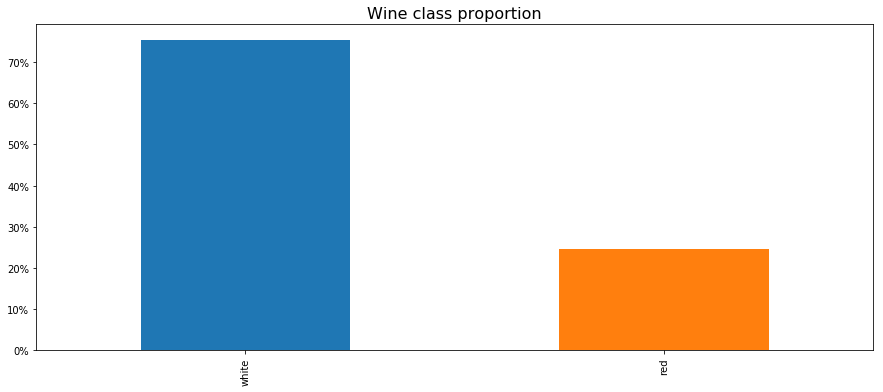

In [74]:
data = wines["style"].value_counts(normalize=True)
data.plot(kind='bar',figsize=(15,6))
plt.title("Wine class proportion",fontsize= 16)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

## Basic exploratory analysis

In [75]:
wines.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


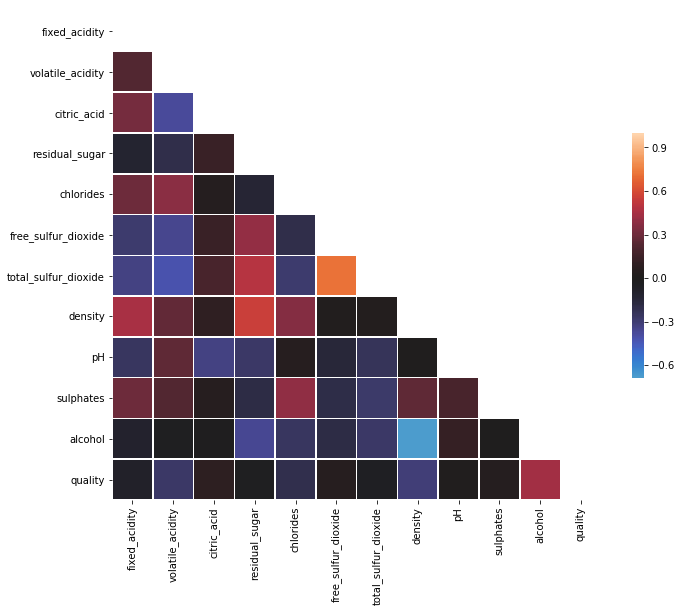

In [76]:
# Compute the correlation matrix
corr=wines.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [77]:
# lets get some grouped stats for both clasees
wines.groupby(['style']).mean()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
style,,,,,,,,,,,,
red,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
white,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909


It seems that in average, red wine usually is less acid than white wine (the opposite is true when we look at `volatile_acidity` feature). 
The 'residual_sugar' in average is almost 3 times bigger for a white wine.
The feature 'free_sulfur_dioxide' is highly and positive correlated with `total_sulfur_dioxide', which kinf of makes sense.


## We will scale our continuos features

In [78]:
#Scaling the continuos variables
wines_scale = wines.copy()
scaler = preprocessing.StandardScaler()
columns = wines.columns[0:12]
wines_scale[columns] = scaler.fit_transform(wines_scale[columns])
wines_scale.head()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,style
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,-0.937230,red
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,-0.937230,red
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,-0.937230,red
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,0.207999,red
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,-0.937230,red


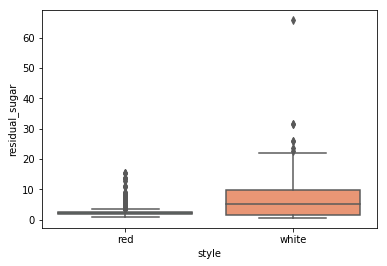

In [79]:
sns.boxplot(x="style", y="residual_sugar", data=wines, palette="Set2" )

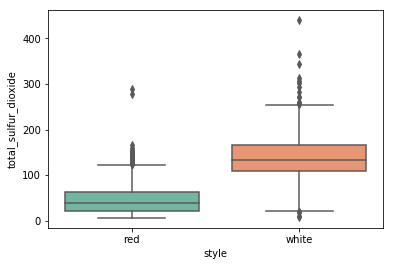

In [80]:
sns.boxplot(x="style", y="total_sulfur_dioxide", data=wines, palette="Set2" )

We confirm the facts seen after grouping by classes and calculating average stats for the features. Also, we can see a few outliers.

## Encoding the output vector

In [102]:
label_encoder = preprocessing.LabelEncoder()
le = label_encoder.fit_transform(wines_scale['style'])
print(le)
print(wines_scale.info())
print(wines_scale.head(5))

[0 0 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
fixed_acidity           6497 non-null float64
volatile_acidity        6497 non-null float64
citric_acid             6497 non-null float64
residual_sugar          6497 non-null float64
chlorides               6497 non-null float64
free_sulfur_dioxide     6497 non-null float64
total_sulfur_dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null float64
style                   6497 non-null object
dtypes: float64(12), object(1)
memory usage: 659.9+ KB
None
   fixed_acidity  volatile_acidity  citric_acid  ...     alcohol   quality  style
0       0.142473          2.188833    -2.192833  ...   -0.915464 -0.937230    red
1       0.451036          3.282235    -2.192833  ...  

## Spliting training and test datasets

In [103]:
X_train, X_test, y_train, y_test=train_test_split(wines_scale.iloc[:,0:12], le, test_size=0.33, random_state=8)

In [95]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4352, 12)
(2145, 12)
(4352,)
(2145,)


## Now we create a neural network model

In [100]:
# Initialize the constructor
model=Sequential()
# Add an input layer 
model.add(Dense(13, activation='relu', input_shape=(12,)))

# Add one hidden layer 
model.add(Dense(60, activation='relu'))
model.add(Dense(30, activation='relu'))

# Add an output layer 
model.add(Dense(1, activation='relu'))

model.output_shape
# Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 13)                169       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                840       
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 2,870
Trainable params: 2,870
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
model.fit(X_train, y_train,epochs=400, batch_size=100, verbose=0, callbacks=[EarlyStopping(monitor='acc', patience=200)])

## Now lets evaluate the model

In [106]:
# over the training set
y_pred=model.predict_classes(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[1059   11]
 [   3 3279]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1070
           1       1.00      1.00      1.00      3282

   micro avg       1.00      1.00      1.00      4352
   macro avg       1.00      0.99      1.00      4352
weighted avg       1.00      1.00      1.00      4352



In [107]:
# over the test set
y_pred=model.predict_classes(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 521    8]
 [   7 1609]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       529
           1       1.00      1.00      1.00      1616

   micro avg       0.99      0.99      0.99      2145
   macro avg       0.99      0.99      0.99      2145
weighted avg       0.99      0.99      0.99      2145



The neural network proposed has a high predictive power